# Kaggle - Retail Data Analytics 

### Context
The Challenge - One challenge of modeling retail data is the need to make decisions based on limited history. Holidays and select major events come once a year, and so does the chance to see how strategic decisions impacted the bottom line. In addition, markdowns are known to affect sales – the challenge is to predict which departments will be affected and to what extent.

### Content
You are provided with historical sales data for 45 stores located in different regions - each store contains a number of departments. The company also runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks.

### The Task
    - Predict the department-wide sales for each store for the following year;
    - Model the effects of markdowns on holiday weeks;
    - Provide recommended actions based on the insights drawn, with prioritization placed on largest business 
    impact;

#### Imports

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

/Users/Eduardo/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Data Gathering

In [2]:
features_data = pd.read_csv('features-data-set.csv')
sales_data = pd.read_csv('sales-data-set.csv')
stores_data = pd.read_csv('stores-data-set.csv')

### Features
Contains additional data related to the store, department, and regional activity for the given dates.

    - Store - the store number;
    - Date - the week;
    - Temperature - average temperature in the region;
    - Fuel_Price - cost of fuel in the region;
    - MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA;
    - CPI - the consumer price index;
    - Unemployment - the unemployment rate;
    - IsHoliday - whether the week is a special holiday week;

In [3]:
features_data.sample(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
4451,25,09/09/2011,67.51,3.738,NaN,NaN,NaN,NaN,NaN,209.022556,7.274,True
13,1,07/05/2010,72.55,2.835,NaN,NaN,NaN,NaN,NaN,210.339968,7.808,False
2368,14,19/02/2010,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,False
4929,28,21/05/2010,76.20,3.120,NaN,NaN,NaN,NaN,NaN,126.184387,14.099,False
5391,30,06/04/2012,69.02,3.891,21.39,NaN,4.09,NaN,2364.16,221.073764,6.891,False


### Sales
Historical sales data, which covers to 2010-02-05 to 2012-11-01. Within this tab you will find the following fields:

    - Store - the store number;
    - Dept - the department number;
    - Date - the week;
    - Weekly_Sales -  sales for the given department in the given 
    store;
    - IsHoliday - whether the week is a special holiday week;

In [4]:
sales_data.sample(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
379369,40,85,19/03/2010,1515.43,False
164805,17,71,29/10/2010,1732.66,False
186812,19,95,28/10/2011,87104.54,False
32414,4,22,25/02/2011,20190.39,False
364583,39,27,31/12/2010,1967.34,True


### Stores
Anonymized information about the 45 stores, indicating the type and size of store.

In [5]:
stores_data.sample(5)

,Store,Type,Size
32,33,A,39690
27,28,A,206302
31,32,A,203007
30,31,A,203750
43,44,C,39910


## Data Wrangling

In [6]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [7]:
features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [8]:
features_data['Date'] = pd.to_datetime(features_data['Date'])
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

In [9]:
store_1_features = features_data.query('Store == 1')
store_1_features.sample(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
36,1,2010-10-15,67.18,2.720,NaN,NaN,NaN,NaN,NaN,211.813744,7.838,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
105,1,2012-10-02,48.02,3.409,13925.06,6927.23,101.64,8471.88,6886.04,220.265178,7.348,True
152,1,2013-04-01,41.73,3.161,1214.08,25366.33,15.01,72.36,3940.02,224.080983,6.525,False
92,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False


In [10]:
store_1_sales = sales_data.query('Store == 1')

store1 = pd.merge(store_1_features, store_1_sales, on='Date', how='inner')

store1.head()

,Store_x,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_x,Store_y,Dept,Weekly_Sales,IsHoliday_y
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1,1,24924.50,False
1,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1,2,50605.27,False
2,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1,3,13740.12,False
3,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1,4,39954.04,False
4,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1,5,32229.38,False


In [11]:
store1.drop(['Store_x', 'IsHoliday_x', 'Store_y'], axis=1, inplace=True)

store1['Year_Week'] = store1['Date'].dt.strftime('%Y%U')

store1['Year_Week'] = store1['Date'].dt.strftime('%Y%U')

store1.head()

,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Dept,Weekly_Sales,IsHoliday_y,Year_Week
0,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,24924.50,False,201018
1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2,50605.27,False,201018
2,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,3,13740.12,False,201018
3,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,4,39954.04,False,201018
4,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,32229.38,False,201018


## Forecasting 

With only Feature Engineering and one initial variable.

In [12]:
data = store1.query('Dept == 1').copy()

In [13]:
data.drop(['Temperature',
           'Fuel_Price',
           'MarkDown1',
           'MarkDown2',
           'MarkDown3',
           'MarkDown4',
           'MarkDown5',
           'CPI',
           'Unemployment',
           'IsHoliday_y',
           'Date'], axis=1, inplace=True)

In [14]:
data.head()

,Dept,Weekly_Sales,Year_Week
0,1,24924.50,201018
73,1,46039.49,201048
145,1,41595.55,201007
218,1,19403.54,201008
290,1,21827.90,201018


### Feature Engineering

In [15]:
data2 = data.copy()

data2['Last_Week_Sales'] = data2['Weekly_Sales'].shift()

data2['Last_Week_Diff'] = data2['Weekly_Sales'].diff()

data2 = data2.dropna()

data2.head()

,Dept,Weekly_Sales,Year_Week,Last_Week_Sales,Last_Week_Diff
73,1,46039.49,201048,24924.50,21114.99
145,1,41595.55,201007,46039.49,-4443.94
218,1,19403.54,201008,41595.55,-22192.01
290,1,21827.90,201018,19403.54,2424.36
363,1,21043.39,201048,21827.90,-784.51


In [16]:
data2['Year_Week'] = data2['Year_Week'].astype(int)

In [17]:
data2.drop_duplicates(subset='Year_Week', inplace=True)

### Setting a baseline

#### Mean Squared Log Error - https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error


##### Baseline = 0.1616 | Random Forest Regressor = 0.0960


In [18]:
week_range = data2['Year_Week'].values

# Train Test need df with at least one value
week_range = np.delete(week_range, week_range.argmin())

In [19]:
week_range.sort()
week_range

array([201005, 201006, 201007, 201008, 201010, 201011, 201012, 201014,
       201015, 201016, 201017, 201018, 201019, 201020, 201021, 201023,
       201024, 201025, 201027, 201028, 201029, 201030, 201032, 201033,
       201034, 201035, 201036, 201037, 201038, 201040, 201041, 201042,
       201043, 201044, 201046, 201047, 201048, 201049, 201050, 201051,
       201052, 201101, 201102, 201103, 201104, 201106, 201107, 201108,
       201110, 201111, 201112, 201113, 201114, 201115, 201116, 201117,
       201119, 201120, 201121, 201123, 201124, 201125, 201126, 201128,
       201129, 201130, 201131, 201132, 201133, 201134, 201136, 201137,
       201138, 201139, 201140, 201141, 201142, 201143, 201144, 201145,
       201146, 201147, 201149, 201150, 201151, 201152, 201201, 201202,
       201203, 201204, 201205, 201207, 201208, 201209, 201210, 201211,
       201212, 201213, 201214, 201215, 201216, 201217, 201219, 201220,
       201221, 201222, 201223, 201224, 201225, 201226, 201228, 201229,
      

In [20]:
mean_error = []

for week in week_range:
    
        train = data2.query('Year_Week < @week')
        test = data2.query('Year_Week == @week')

        p = test['Last_Week_Sales'].values
        
        error = np.sqrt(mean_squared_log_error(test['Weekly_Sales'].values, p))

        print(week, error)

        mean_error.append(error)
    
    

201005 0.7806805450807186
201006 0.0002706354991097726
201007 0.10150399558044221
201008 0.7625101718265199
201010 0.027963298582026397
201011 0.0506453109044287
201012 0.16963247274699178
201014 0.11949194397111285
201015 0.8925309229398302
201016 0.08608896830175183
201017 0.025061200047883148
201018 0.11772772061055647
201019 0.08330011237169188
201020 0.24775698431601967
201021 0.05320823400764141
201023 0.12948714842213427
201024 0.025649775467718072
201025 0.006910036685043863
201027 0.050573240524908414
201028 0.030880484605990688
201029 0.11024433218097762
201030 0.0013901779708298534
201032 0.1194884299243757
201033 0.013027011251802278
201034 0.0034081717414178314
201035 0.2872784358522882
201036 0.07972854511457861
201037 0.061775166442334495
201038 0.06575212495895322
201040 0.11353899840144877
201041 0.1428042788933599
201042 0.05466736657881732
201043 0.41393393500039366
201044 0.05384526527903688
201046 0.0001764514994402333
201047 0.038183010670730155
201048 0.613629850

In [21]:
np.mean(mean_error)

0.17107278434027337

### Create the model  

In [236]:
mean_error_rf = []

for week in week_range:
        
        train = data2.query('Year_Week < @week')
        test = data2.query('Year_Week == @week')
        
        X_train = train.drop(['Weekly_Sales'], axis=1)
        X_test = test.drop(['Weekly_Sales'], axis=1)
        
        y_train = train['Weekly_Sales'].values
        y_test = test['Weekly_Sales'].values
        
        model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        p = model.predict(X_test)
        
        error = np.sqrt(mean_squared_log_error(y_test, p))

        print(week, error)

        mean_error_rf.append(error)

201005 0.10150399558044221
201006 0.7878272155644375
201007 0.36550653953539225
201008 0.16570119532013372
201010 0.0023308508872830203
201011 0.7445216276408484
201012 0.2616462018983352
201014 0.6364256965398116
201015 0.4094102718433206
201016 0.18234332898215122
201017 0.025987572298372896
201018 0.06049695079716244
201019 0.21789114186245762
201020 0.016607653528431854
201021 0.015967002327400337
201023 0.022574287317487673
201024 0.008399440288384241
201025 0.0029508419480244186
201027 0.01003482223349117
201028 0.049578228314992145
201029 0.07610101226329213
201030 0.06723217764933942
201032 0.006615363337648006
201033 0.006006247328222969
201034 0.0037838284152780233
201035 0.02531865222562857
201036 0.03917870684047031
201037 0.05492316490713023
201038 0.0481413908616819
201040 0.06535246338341061
201041 0.15547534242920058
201042 0.0401014046105761
201043 0.12169174194872667
201044 0.2014820657980998
201046 0.4717457177690534
201047 0.15865105686437175
201048 0.09573616747597

In [237]:
np.mean(mean_error_rf)

0.09607668644512185

### Adding variables

In [24]:
data_new = store1_dept1.copy()

NameError: name 'store1_dept1' is not defined

In [23]:
data_new.drop(['MarkDown1',
           'MarkDown2',
           'MarkDown3',
           'MarkDown4',
           'MarkDown5',
           'Date'], axis=1, inplace=True)

NameError: name 'data_new' is not defined

In [271]:
data_new2 = data_new.copy()

data_new2['Last_Week_Sales'] = data_new2['Weekly_Sales'].shift()

data_new2['Last_Week_Diff'] = data_new2['Weekly_Sales'].diff()

data_new2 = data_new2.dropna()

data_new2.head()

,Temperature,Fuel_Price,CPI,Unemployment,Dept,Weekly_Sales,IsHoliday_y,Year_Week,Last_Week_Sales,Last_Week_Diff
1,38.51,2.548,211.242170,8.106,1,46039.49,True,201048,24924.50,21114.99
2,39.93,2.514,211.289143,8.106,1,41595.55,False,201007,46039.49,-4443.94
3,46.63,2.561,211.319643,8.106,1,19403.54,False,201008,41595.55,-22192.01
4,46.50,2.625,211.350143,8.106,1,21827.90,False,201018,19403.54,2424.36
5,57.79,2.667,211.380643,8.106,1,21043.39,False,201048,21827.90,-784.51


In [273]:
data_new2['Year_Week'] = data_new2['Year_Week'].astype(int)
data_new2.drop_duplicates(subset='Year_Week', inplace=True)

In [274]:
mean_error_rf = []

for week in week_range:
        
        train = data_new2.query('Year_Week < @week')
        test = data_new2.query('Year_Week == @week')
        
        X_train = train.drop(['Weekly_Sales'], axis=1)
        X_test = test.drop(['Weekly_Sales'], axis=1)
        
        y_train = train['Weekly_Sales'].values
        y_test = test['Weekly_Sales'].values
        
        model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        p = model.predict(X_test)
        
        error = np.sqrt(mean_squared_log_error(y_test, p))

        print(week, error)

        mean_error_rf.append(error)

201005 1.047111862082538
201006 0.9360547576906502
201007 0.3810773992441252
201008 0.6703553506136775
201010 0.2231948929313461
201011 0.2993865014679251
201012 0.17480067762723728
201014 0.18855585819988718
201015 0.711616625265
201016 0.27955433660324935
201017 0.08426302756330273
201018 0.01339336347665565
201019 0.03700632418420824
201020 0.20767409050100305
201021 0.06628702674827558
201023 0.009473043329991881
201024 0.0018250368680181595
201025 0.005278385934746055
201027 0.06485408300529727
201028 0.04533765349142982
201029 0.0797070241675133
201030 0.059358394743412646
201032 0.02858202650918784
201033 0.0062734186813671045
201034 0.012591828652057657
201035 0.5680068249453445
201036 0.11797002152703939
201037 0.03509779602571861
201038 0.04545888362943451
201040 0.006834184787425812
201041 0.2126383118451649
201042 0.006899796552126247
201043 0.35855115751205346
201044 0.03160983750260726
201046 0.1666493581525632
201047 0.12122844592763471
201048 0.16413804392560927
201049 

In [275]:
np.mean(mean_error_rf)

0.12212871613549252

In [276]:
mean_error_rf = []

for week in week_range:
        
        train = data_new2.query('Year_Week < @week')
        test = data_new2.query('Year_Week == @week')
        
        X_train = train.drop(['Weekly_Sales'], axis=1)
        X_test = test.drop(['Weekly_Sales'], axis=1)
        
        y_train = train['Weekly_Sales'].values
        y_test = test['Weekly_Sales'].values
        
        model = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
        model.fit(X_train, y_train)

        p = model.predict(X_test)
        
        error = np.sqrt(mean_squared_log_error(y_test, p))

        print(week, error)

        mean_error_rf.append(error)

201005 1.047111889296767
201006 0.8619957160946061
201007 0.28665130799066674
201008 0.555584532136594
201010 0.644335720944925
201011 0.252230699438897
201012 0.050232264473461186
201014 0.44542954012089275
201015 0.4024598716212182
201016 0.45485483982218966
201017 0.3960055665369602
201018 0.09189808799283128
201019 0.22772739524204155
201020 0.46083048568999274
201021 0.38269818448177517
201023 0.24596558226745024
201024 0.30971781819079247
201025 0.28790020986312825
201027 0.21030455983327023
201028 0.2159991799955634
201029 0.3169497902224929
201030 0.30313581617559215
201032 0.281702352257831
201033 0.2583934229849234
201034 0.24583516981386744
201035 0.7632115165950406
201036 0.165654789429178
201037 0.07021095599303173
201038 0.13362231484579645
201040 0.1254673212848214
201041 0.27222754098712265
201042 0.2078299886073225
201043 0.6147881948613314
201044 0.2524947801578161
201046 0.0846537609785809
201047 0.12057951365038555
201048 0.7770278525600407
201049 0.1099507204365384

In [277]:
np.mean(mean_error_rf)

0.23695048324449186

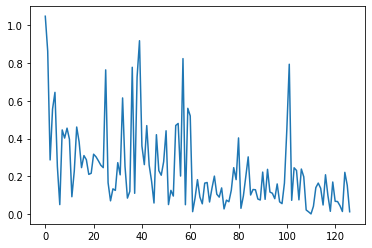

In [286]:
pd.Series(mean_error_rf).plot()

### Model Export

In [25]:
sample = data2.copy()

In [27]:
X = sample.drop(['Weekly_Sales'], axis=1)
y = sample['Weekly_Sales']

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

In [29]:
X_test.to_csv("X_test.csv", index = False)

In [29]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [30]:
import pickle

pickle_out = open('model.pkl', 'wb')
pickle.dump(model, pickle_out)
pickle_out.close()